In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pickle
import itertools
import tqdm
# import hypergrad as hg
from mlmodel import *
import utils
import numpy as np
from sparsemax import Sparsemax
from argparse import ArgumentParser
from ZSTL_model import ZSTL

In [2]:
net = FuncRecursiveNet([
    FLinearLayer(1, False)
])

In [3]:
d = 8
dm = 5
T = 100
n = 10
dict_k = 6
shape_record = {}
shape_record[0] = [(1,d)]

np.random.seed(666)
L_gt = np.random.randn(d,dict_k)

D_gt = np.random.randn(dm,dict_k)

s_train = np.random.uniform(0, 2, size=(dict_k, T))
s_train[s_train>=1] = 0
#print(s_train)

s_kb = np.random.uniform(0, 2, size=(dict_k, 10))
s_kb[s_kb>=1] = 0
#print(s_val)
s_test = np.random.uniform(0, 2, size=(dict_k, T))
s_test[s_test>=1] = 0
#print(s_test)

w_train = L_gt @ s_train
w_kb = L_gt @ s_kb
w_test = L_gt @ s_test

a_train = D_gt @ s_train
a_kb = D_gt @ s_kb
a_test = D_gt @ s_test


ones = np.atleast_2d(np.ones(n))

x_kb = np.random.normal(0, 1.0, size=(d-1,n))
x_kb = np.vstack((ones, x_kb))

x_train = np.random.normal(0, 1.0, size=(d-1,n))
x_train = np.vstack((ones, x_train))


x_test = np.random.normal(0, 1.0, size=(d-1,n))
x_test = np.vstack((ones, x_test))

y_train = utils.sigmoid(w_train.T @ x_train)
y_train[y_train >=0.5] = 1
y_train[y_train <0.5] = 0

y_test = utils.sigmoid(w_test.T @x_test)
y_test[y_test >=0.5] = 1
y_test[y_test <0.5] = 0


y_kb = utils.sigmoid(w_kb.T @ x_kb)
y_kb[y_kb >=0.5] = 1
y_kb[y_kb <0.5] = 0

w_train = w_train.T
w_test = w_test.T
w_kb = w_kb.T
a_train = a_train.T
a_test = a_test.T
a_kb = a_kb.T
x_train = x_train.T
x_test = x_test.T
x_kb = x_kb.T

print('w_train ', w_train.shape)
print('w_test ', w_test.shape)
print('w_kb ', w_kb.shape)
print('a_train ', a_train.shape)
print('a_test ', a_test.shape)
print('a_kb ', a_kb.shape)
print('x_kb ', x_kb.shape)
print('x_train ', x_train.shape)
print('x_test ', x_test.shape)
print('y_train ', y_train.shape, np.sum(y_train, axis=1))
print('y_test ', y_test.shape)
print('y_kb ', y_kb.shape)

w_train  (100, 8)
w_test  (100, 8)
w_kb  (10, 8)
a_train  (100, 5)
a_test  (100, 5)
a_kb  (10, 5)
x_kb  (10, 8)
x_train  (10, 8)
x_test  (10, 8)
y_train  (100, 10) [7. 7. 5. 9. 7. 5. 6. 7. 7. 9. 8. 6. 6. 5. 4. 4. 8. 9. 9. 6. 9. 8. 6. 6.
 4. 6. 8. 7. 8. 7. 5. 3. 9. 6. 6. 8. 4. 6. 9. 7. 7. 9. 9. 5. 7. 3. 3. 6.
 7. 9. 8. 7. 9. 6. 9. 5. 9. 9. 8. 6. 6. 9. 5. 4. 9. 9. 9. 7. 7. 8. 8. 7.
 4. 9. 8. 9. 7. 7. 6. 6. 8. 9. 7. 7. 8. 6. 4. 8. 7. 8. 6. 7. 9. 7. 7. 7.
 8. 3. 9. 5.]
y_test  (100, 10)
y_kb  (10, 10)


w_train  (100, 8)
w_test  (100, 8)
w_kb  (10, 8)
a_train  (100, 5)
a_test  (100, 5)
a_kb  (10, 5)
x_kb  (10, 8)
x_train  (10, 8)
x_test  (10, 8)
y_train  (100, 10) [6. 9. 5. 4. 9. 9. 9. 7. 7. 8. 8. 7. 4. 9. 8. 9. 7. 7. 6. 6. 8. 9. 7. 7.
 8. 6. 4. 8. 7. 8. 6. 7. 9. 7. 7. 7. 8. 3. 9. 5. 9. 8. 7. 8. 9. 4. 9. 9.
 8. 7. 8. 8. 7. 4. 6. 8. 7. 9. 9. 9. 8. 8. 4. 7. 8. 9. 5. 7. 9. 5. 7. 3.
 8. 9. 9. 5. 8. 6. 8. 3. 7. 7. 9. 8. 4. 4. 7. 6. 3. 9. 7. 8. 7. 4. 7. 8.
 8. 9. 8. 9.]
y_test  (100, 10)
y_kb  (10, 10)


In [4]:
kb_data = utils.Dataset([(a_kb[t,:], [w_kb[t,:]], x_kb, np.expand_dims(y_kb[t, :], axis=2)) for t in range(a_kb.shape[0])])

train_data = utils.Dataset([(a_train[t,:], [w_train[t,:]], x_train, np.expand_dims(y_train[t, :], axis=2)) for t in range(a_train.shape[0])])

test_data = utils.Dataset([(a_test[t,:], [w_test[t,:]], x_test, np.expand_dims(y_test[t, :], axis=2)) for t in range(a_test.shape[0])])

kb_loader = DataLoader(kb_data, batch_size=a_kb.shape[0], shuffle=False)
train_loader = DataLoader(train_data, batch_size=15, shuffle=True)
test_loader = DataLoader(test_data, batch_size=a_test.shape[0], shuffle=True)

In [5]:
support_a, support_w, support_x, support_y = next(iter(kb_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
print(support_a.size(), support_w.size(), support_x.size(), support_y.size())

torch.Size([10, 1, 5]) torch.Size([10, 1, 8]) torch.Size([10, 10, 8]) torch.Size([10, 10, 1])


In [6]:
support_a, support_w, support_x, support_y = next(iter(kb_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()
dm = support_a.size()[0]
print(dm)

param_dict = {}
param_dict['rho'] = 0.00001
param_dict['mu'] = 0.00001
param_dict['loss'] = 'binary class'
param_dict['outer lr'] = 5e-4
param_dict['align lr'] = 1e-4
param_dict['dm'] = dm
param_dict['d'] = d
param_dict['model_shape'] = shape_record


ZSTL_model = ZSTL(support_w, support_a, support_x, net, param_dict)

5


 mean test loss 0.7719999999999999 with mse loss in atten align 0.0003693978360388428
370/2000 o_loss 0.44343359079405975; mean test loss 0.7710000000000001 with mse loss in atten align 0.00041838016477413476
380/2000 o_loss 0.3892139629557884; mean test loss 0.763 with mse loss in atten align 0.0005140719003975391
390/2000 o_loss 0.4238787653817174; mean test loss 0.7620000000000001 with mse loss in atten align 0.00038323685294017196
400/2000 o_loss 0.3569200733366112; mean test loss 0.7680000000000001 with mse loss in atten align 0.00046318030217662454
410/2000 o_loss 0.43864952462802953; mean test loss 0.7640000000000002 with mse loss in atten align 0.0004302829911466688
420/2000 o_loss 0.3959319588068562; mean test loss 0.7730000000000001 with mse loss in atten align 0.00043761354754678905
430/2000 o_loss 0.43462563965974066; mean test loss 0.765 with mse loss in atten align 0.0003728602023329586
440/2000 o_loss 0.5161923209942567; mean test loss 0.7800000000000001 with mse loss in

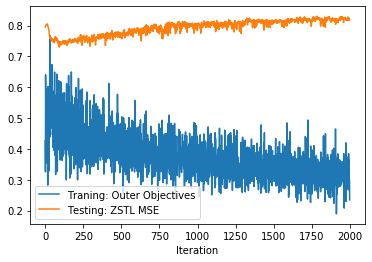

0

In [7]:
ZSTL_model.train(train_loader, test_loader, max_iter=2000)